In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

<h2>Plots of the coefficients of the predictors for each participant <h2>

<p>Let's do a simple bar plot, with significant asterisks.</p>

In [2]:
#helper function to calculate number of subplots
def calc_subplots(n_datasets,ncolumns):
    subplots = n_datasets
    columns = ncolumns

    rows = subplots // columns

    if subplots % columns != 0:
        rows +=1 

    return (rows, columns)

C:\Users\Rishi\AppData\Local\Temp\ipykernel_6576\4070671445.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels)
C:\Users\Rishi\AppData\Local\Temp\ipykernel_6576\4070671445.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_labels)


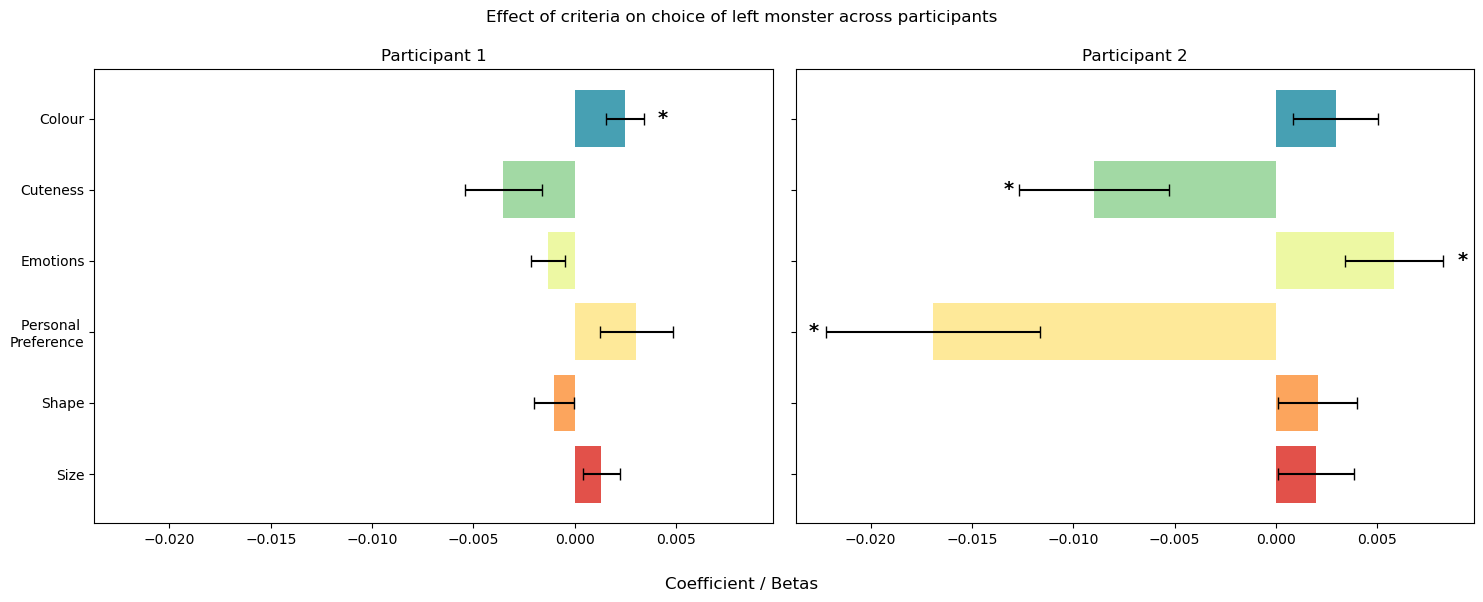

In [85]:
results_folder = os.listdir('LogisticModel_Results')
ppID = 0 #counter for the participants (important later for labelling subplots)

rows, cols = calc_subplots(len(results_folder), 2)
figsize = (15,6)
fig, axes = plt.subplots(rows,cols, figsize = (15,6), sharex=True, sharey=True)
color_palette = sns.color_palette(palette='Spectral') #grab a colour palette for the bars

for index, participant_data in enumerate(results_folder):
    data = pd.read_csv(f'LogisticModel_Results/{participant_data}') #get the dataframe
    data = data.sort_values(by='Predictors', ascending=False) #setting the order to descending so they appear from top to bottom on the y axis (colors to size)

    ax = axes.flatten()[index] #do this so it effortlessly loops over the subplot axes and plots the participant data

    predictors = data['Predictors']#get the x axis values which will be the coefficients
    coefficients = data['Coef.']
    error = data['Std.Err.'] * 0.95 #for 95% CI
    
    ax.barh(predictors,coefficients,xerr=error, align='center', capsize=4, color=color_palette)
    ax.set_title(f'Participant {index + 1}')
    

    #adding asterisks for significant predictors
    sig_predictors = data.loc[data['pvalues'] <= 0.05, 'Predictors'].astype(str)

    for i, row in data.iterrows(): #for each row in the data
        predictor = row['Predictors'] #get the predictor value for that row
        coeff = row['Coef.'] #get the corresponding coefficient value
        stderr = row['Std.Err.']

        if predictor in sig_predictors.values: #and if the predictor is in the list of significant predictors
            xpos = coeff + (stderr + 0.0006)*np.sign(coeff) #x position of the asterisk, offsetting it by 
            #note the 0.0006 was a random number i got by playing around to ensure the asterisk lands a little over
            #the upper bound of the error bar
            ypos = predictor
            ax.text(xpos, ypos, '*', ha='left', va='center', fontsize=14, fontweight='bold')

    
    ytick_labels = ['Colour', 'Cuteness', 'Emotions','Personal \nPreference','Shape','Size'] #reset original labels from the table
    ytick_labels = sorted(ytick_labels, reverse=True) #rearranging the above labels in descending order so they are placed correctly from top to bottom, according to how the predictors were sorted (descending order) before plotting 
    ax.set_yticklabels(ytick_labels)

fig.supxlabel('Coefficient / Betas')
fig.suptitle('Effect of criteria on choice of left monster across participants')
plt.tight_layout(pad=1.3)
    
    









<h2>Plot to visualize the frequency of monsters chosen</h2>

<p>Here we are using raw data to visualize how frequently each monster was picked across all participants by looking, at the mean counts.</p>

In [ ]:
#define the image paths for later annotation of the monster images on the plot
imagesPath = 'C:\Master Biosciences\Hiwi Job Heidelberg\monsters'
imagesList = [image for image in os.listdir(imagesPath) if image.endswith('.png')]

folder = os.listdir('Prolific_Results')
n_participants = len(folder)

combined_df = pd.DataFrame([])

for index, file_name in enumerate(folder):
    data = pd.read_csv(f'Prolific_Results/{file_name}')

    colstodrop = ['stimulus', 'url','success','plugin_version','view_history','sort_criteria', 'init_locations',
                  'final_locations', 'question_order','moves']

    firstBlock = data.loc[(data['trial_index'] >= 4) & (data['trial_index'] <=94)]
    firstBlock = firstBlock.drop(colstodrop, axis=1)

    #add participant ID for grouping purposes

    #create a new column which will store the monster chosen by participant
    insert_position = firstBlock.columns.get_loc('rightstim') + 1 #i want the chosen monster column to be inserted after the rightstim column
    firstBlock.insert(insert_position, 'Monster_Picked', 0) #named it to Monster_Picked to avoid confusion with the Chosen_Monster column with 1s and 0s
    firstBlock.insert(index, 'Participant_ID', index + 1)

    #assign the value of the chosen monster based off the key press
    firstBlock.loc[firstBlock['response'] == "ArrowRight", 'Monster_Picked'] = firstBlock['rightstim']
    firstBlock.loc[firstBlock['response'] == "ArrowLeft", 'Monster_Picked'] = firstBlock['leftstim']

    #the combined df will hold all the data for all the participants
    combined_df = pd.concat([combined_df,firstBlock], ignore_index=True)


#For plotting we need to :
#Find the counts of the chosen monsters
monster_counts = combined_df.groupby(['Participant_ID','Monster_Picked']).size().reset_index(name='Count')

#get the means and std for the monsters
aggregated_data = monster_counts.groupby(['Monster_Picked'])['Count'].agg(['mean','std','count']).reset_index()

In [138]:
monster_counts

,Participant_ID,Monster_Picked,Count
0,1,obj00.png,7
1,1,obj01.png,8
2,1,obj02.png,2
3,1,obj03.png,6
4,1,obj04.png,4
5,1,obj05.png,8
6,1,obj06.png,3
7,1,obj07.png,12
8,1,obj09.png,5
9,1,obj11.png,9


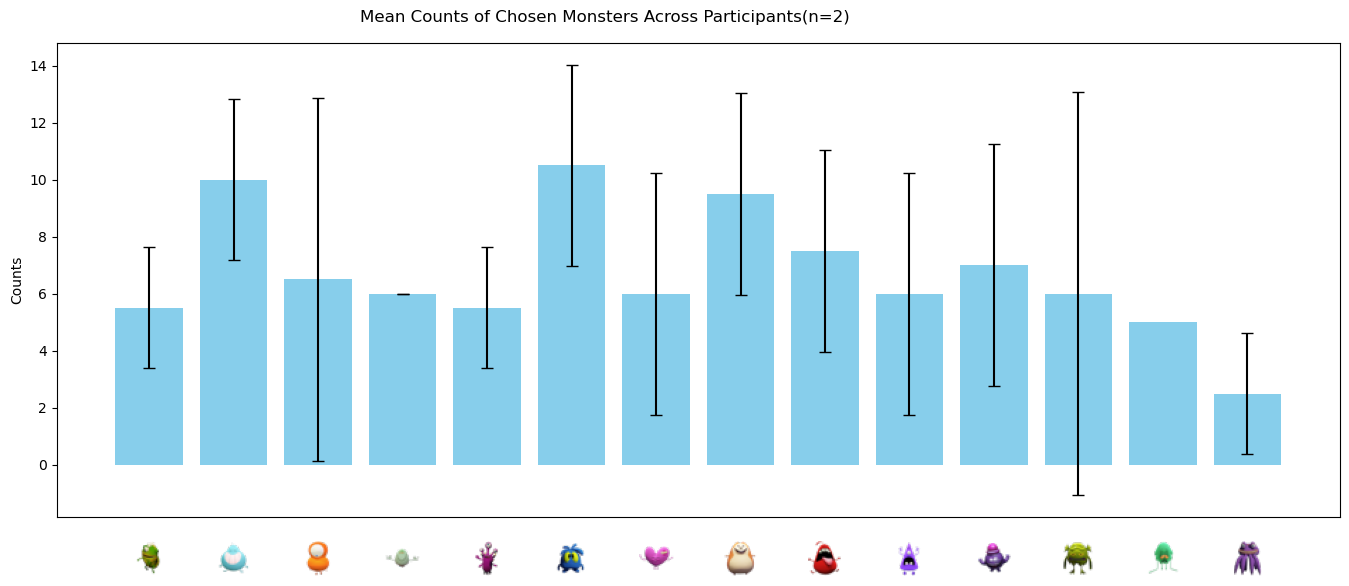

In [162]:
fig, axes = plt.subplots(figsize=figsize)
axes.bar(aggregated_data['Monster_Picked'], aggregated_data['mean'], yerr=aggregated_data['std'], capsize=4, color='skyblue')
axes.set_xticks([])
for j, image_path in enumerate(imagesList):
        ##logic
        #load image
        #get thumbnail from image object
        #create a numpy array for using np.asarray as OffsetImage works with numpy arrays
        #create an OffsetImage object (this makes it possible to move the thumbnail to wherever we want) == thumbnail
        #use Annotationbox to place it at (j,0) and then offset it by -30 pts so they appear below the xaxis

        image = Image.open(f"../monsters/{image_path}")
        image.thumbnail((25,25))
        array_image = np.asarray(image)
        thumbnail = OffsetImage(array_image, zoom=1)
        xtick_image = AnnotationBbox(thumbnail, (j,0), xybox = (0,-30), frameon=False,
                                     xycoords=('data','axes fraction'), boxcoords="offset points", pad=0)
        axes.add_artist(xtick_image)
        

fig.suptitle(f'Mean Counts of Chosen Monsters Across Participants(n={n_participants})')
plt.ylabel('Counts')
plt.tight_layout()
